In [1]:
from pyddm import Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from utils import *
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter, OverlayChain, OverlayPoissonMixture
from pyddm.functions import fit_adjust_model, display_model
from pyddm import Fittable, Fitted, Sample
from pyddm.models import LossRobustBIC, LossRobustLikelihood
import scipy.stats as stat
import pyddm.plot
import pyddm as ddm

In [2]:
files = os.listdir('data/')
comb_data = pd.concat([extract_data(fname) for fname in files]).reset_index(drop=True)
comb_data['bumps_'] = '0_noisy'
comb_data.loc[comb_data['bumps'] == 'single', 'bumps_'] = '1_single'
comb_data.loc[comb_data['bumps'] == 'center', 'bumps_'] = '1_center'
comb_data = comb_data.loc[comb_data['rt'] < 10].reset_index(drop = True)

In [3]:
samp = Sample.from_pandas_dataframe(comb_data, rt_column_name='rt', choice_column_name='response')

In [30]:
model_fit = Model(name='Simple model (fitted)',
                  drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
                  noise=NoiseConstant(noise=Fittable(minval=.1, maxval=4)),
                  bound=BoundConstant(B=Fittable(minval=.1, maxval=5)),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.005, T_dur=10, 
                     )


In [32]:
fit_model = fit_adjust_model(sample=samp, model=model_fit, verbose=False, lossfunction=LossRobustLikelihood)


Info: Params [1.43382962e+00 3.02144851e+00 4.15464191e+00 1.63406612e-03] gave 27235.248099915323


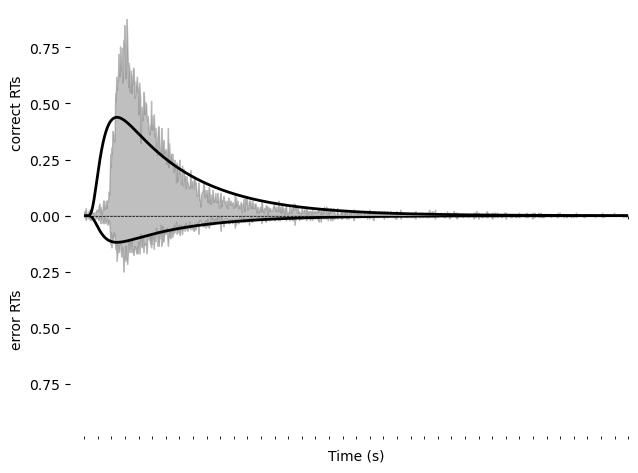

In [34]:
pyddm.plot.plot_fit_diagnostics(model=fit_model, sample=samp)


In [35]:
comb_data

,participant,means,direction,bumps,diff_dir,trials.thisN,difference,incorrect choice,key_resp,rt,cond,accuracy,response,bumps_
0,25353.0,64.0,1.0,single,1.0,0.0,8.0,left,left,3.881548,chart,False,-1,1_single
1,25353.0,48.0,1.0,noisy,-1.0,1.0,-6.0,right,right,7.387671,chart,False,-1,0_noisy
2,25353.0,53.0,1.0,noisy,-1.0,2.0,-10.0,left,right,6.337773,chart,True,1,0_noisy
3,25353.0,64.0,-1.0,center,-1.0,3.0,-8.0,left,right,3.151569,chart,True,1,1_center
4,25353.0,60.0,1.0,center,1.0,4.0,8.0,left,right,5.806216,chart,True,1,1_center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11434,908388.0,60.0,1.0,noisy,-1.0,285.0,-8.0,left,left,2.442362,chart,False,-1,0_noisy
11435,908388.0,49.0,1.0,single,-1.0,286.0,-12.0,right,left,0.798230,chart,True,1,1_single
11436,908388.0,38.0,-1.0,single,-1.0,287.0,-11.0,left,right,0.681007,chart,True,1,1_single
11437,908388.0,62.0,-1.0,center,-1.0,288.0,-12.0,right,left,0.802785,chart,True,1,1_center


# Varying parameters

In [5]:
class DriftDifference(ddm.models.Drift):
    name = "Drift depends linearly on Difference"
    required_parameters = ["driftdiff"] # <-- Parameters we want to include in the model
    required_conditions = ["difference"] # <-- Task parameters ("conditions"). Should be the same name as in the sample.
    
    # We must always define the get_drift function, which is used to compute the instantaneous value of drift.
    def get_drift(self, conditions, **kwargs):
        return self.driftdiff * conditions['difference']

In [ ]:
model_dd = Model(name='Drift varies with difference',
                 drift=DriftDifference(driftdiff=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=Fittable(minval=.1, maxval=4)),
                 bound=BoundConstant(B=Fittable(minval=.1, maxval=5)),
                 # Since we can only have one overlay, we use
                 # OverlayChain to string together multiple overlays.
                 # They are applied sequentially in order.  OverlayNonDecision
                 # implements a non-decision time by shifting the
                 # resulting distribution of response times by
                 # `nondectime` seconds.
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.001, dt=.01, T_dur=10)

# Fitting this will also be fast because PyDDM can automatically
# determine that DriftCoherence will allow an analytical solution.
fit_model_rs = fit_adjust_model(sample=samp, model=model_dd, verbose=False, lossfunction=LossRobustLikelihood)